In [ ]:
import glob
import os
import time
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [43]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)


In [56]:
x_train[0].shape

(32, 32, 3)

In [ ]:
input_encoder = (32, 32, 3)
input_decoder = (2,)

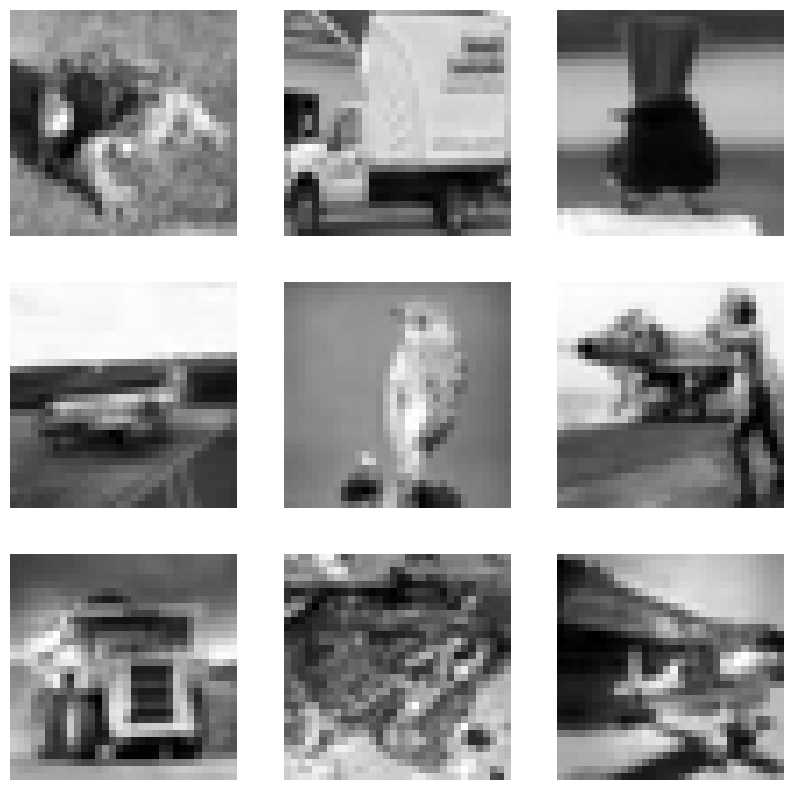

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).\
shuffle(60000).batch(128)
plt.figure(figsize=(10, 10))
for images in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i,:,:,0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
def encoder(input_encoder):

    inputs = keras.Input(shape=input_encoder, name='input_layer')
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)


    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)


    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)


    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)


    flatten = layers.Flatten()(x)
    bottleneck = layers.Dense(2, name='dense_1')(flatten)
    model = tf.keras.Model(inputs, bottleneck, name="Encoder")
    return model

In [30]:
def decoder(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')


    x = layers.Dense(4096, name='dense_1')(inputs)
    x = layers.Reshape((8, 8, 64), name='Reshape_Layer')(x)

    x = layers.Conv2DTranspose(64, 3, strides=1, padding='same', name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    outputs = layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid', name='conv_transpose_4')(x)

    model = keras.Model(inputs, outputs, name="Decoder")
    return model

In [31]:
enc = encoder(input_encoder)
dec = decoder(input_decoder)

In [32]:
input_img = keras.Input(shape=input_encoder)
encoded_output = enc(input_img)
decoded_output = dec(encoded_output)
autoencoder = keras.Model(input_img, decoded_output)
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Functional)            │ (None, 2)              │       102,338 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Functional)            │ (None, 32, 32, 1)      │       105,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,875 (812.01 KB)

 Trainable params: 207,107 (809.01 KB)

 Non-trainable params: 768 (3.00 KB)

In [33]:
autoencoder.compile(optimizer='adam', loss='mse')

In [50]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)

391/391 ━━━━━━━━━━━━━━━━━━━━ 356s 910ms/step - loss: 18463.5371 - val_loss: 18631.0879


In [53]:
encoded_imgs = autoencoder(x_test_noisy).numpy()
decoded_imgs = autoencoder(encoded_imgs).numpy()

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv_1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (10000, 32, 32, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(10000, 32, 32, 1), dtype=float32)
  • training=None
  • mask=None

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()